In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime



### osm-netzwerk einlesen

In [2]:
#set_date = "251010" 
#set_date = "251022" 
set_date = "251115" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
#motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

print("number of cycleways:", len(cycleways))
#print("number of motorways:", len(motorways))

number of cycleways: 5468811


In [3]:
cycleways.head()

,osm_id,highway,bicycle,bicycle_forward,bicycle_backward,cycleway,cycleway_left,cycleway_right,cycleway_both,cycleway_lane,...,maxspeed,maxspeed_conditional,maxspeed_backward,maxspeed_forward,maxspeed_type,name,ref,surface,width,geometry
0,99,tertiary,None,None,None,None,None,no,None,None,...,None,None,None,None,None,None,None,asphalt,None,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
1,104,unclassified,None,None,None,None,None,None,no,None,...,50,None,None,None,None,Münzmeisterstraße,None,asphalt,None,"LINESTRING (13.74142 51.02366, 13.74139 51.023..."
2,105,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Altpestitz,None,sett,None,"LINESTRING (13.73698 51.01663, 13.73643 51.016..."
3,107,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Trienter Straße,None,asphalt,None,"LINESTRING (13.73507 51.01914, 13.73505 51.019..."
4,110,residential,None,None,None,None,None,None,no,None,...,50,None,None,None,sign,Heinrich-Greif-Straße,None,concrete:plates,None,"LINESTRING (13.74296 51.02871, 13.74295 51.028..."


In [4]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [60]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated","yes"])) |
    (cycleways["bicycle_backward"].isin(["designated","yes"])) |
    (cycleways["bicycle_forward"].isin(["designated","yes"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk_bicycle"].isin(["designated"])) |  TODO: add "sidewalk:bicycle" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated","yes"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated","yes"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated","yes"])) 
]
len(filtered_cycleways)

1378363

In [61]:
#filtered_cycleways[::10].plot()

In [62]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [63]:
#motorways.plot()

In [64]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 278.312,67 km


In [65]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [66]:


## Points
# https://www.mapillary.com/developer/api-documentation/points?locale=de_DE


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/mapillary_map-feature-points*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_mf_points = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN
cw_marking="marking--discrete--symbol--bicycle"



# filter to cw only
mapillary_mf_points_cw=mapillary_mf_points[mapillary_mf_points.value.isin([cw_marking])]
# drop duplicates if any
mapillary_mf_points_cw=mapillary_mf_points_cw.drop_duplicates(subset=['id'])

mapillary_mf_points_cw


# 2025-11-15 ## -> 123991  features




Dates found in filenames: ['2025-11-16']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
92,POINT (13.11844 52.51132),2025-07-04,1192415705981631,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
191,POINT (13.11838 52.51142),2025-07-04,754181033839454,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
212,POINT (13.11848 52.51128),2025-07-04,1192415672648301,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
384,POINT (13.1013 52.41389),2016-03-25,906821999886958,2016-03-25,marking--discrete--symbol--bicycle,8788,5381
393,POINT (13.11042 52.41413),2024-05-09,1196164411795324,2024-05-09,marking--discrete--symbol--bicycle,8788,5381
...,...,...,...,...,...,...,...
34093348,POINT (9.44338 51.83199),2022-04-12,1141492059960306,2022-04-12,marking--discrete--symbol--bicycle,8621,5424
34093365,POINT (9.44324 51.83205),2020-09-03,181691620518405,2020-09-03,marking--discrete--symbol--bicycle,8621,5424
34093685,POINT (9.44066 51.83462),2020-09-03,3822412344652704,2020-09-03,marking--discrete--symbol--bicycle,8621,5424
34093757,POINT (9.44438 51.83118),2022-04-12,1141492053293640,2022-04-12,marking--discrete--symbol--bicycle,8621,5424


<Axes: xlabel='last_seen_at'>

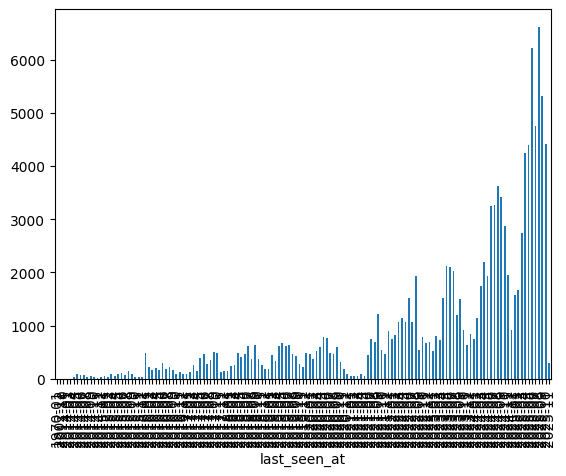

In [67]:
mapillary_mf_points_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


#### Zeitfilter 

In [68]:
##  is newer than 2025-01-01  

# november  2025: 42243


mapillary_mf_points_cw=mapillary_mf_points_cw[mapillary_mf_points_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_mf_points_cw)

42243

In [69]:
mapillary_mf_points_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
92,POINT (13.11844 52.51132),2025-07-04,1192415705981631,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
191,POINT (13.11838 52.51142),2025-07-04,754181033839454,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
212,POINT (13.11848 52.51128),2025-07-04,1192415672648301,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
1492,POINT (13.12827 52.52762),2025-07-05,1793736744822303,2025-07-05,marking--discrete--symbol--bicycle,8789,5372
1558,POINT (13.12844 52.52792),2025-07-05,1793736754822302,2025-07-05,marking--discrete--symbol--bicycle,8789,5372
...,...,...,...,...,...,...,...
34062627,POINT (9.12996 51.49254),2025-07-11,1254463399451446,2025-07-11,marking--discrete--symbol--bicycle,8607,5449
34062649,POINT (9.12818 51.49326),2025-07-11,1096456959003885,2025-07-11,marking--discrete--symbol--bicycle,8607,5449
34062873,POINT (9.12826 51.49326),2025-07-11,1096456939003887,2025-07-11,marking--discrete--symbol--bicycle,8607,5449
34082415,POINT (9.37214 51.66933),2025-08-08,779679107913988,2025-08-08,marking--discrete--symbol--bicycle,8618,5436


<Axes: xlabel='last_seen_at'>

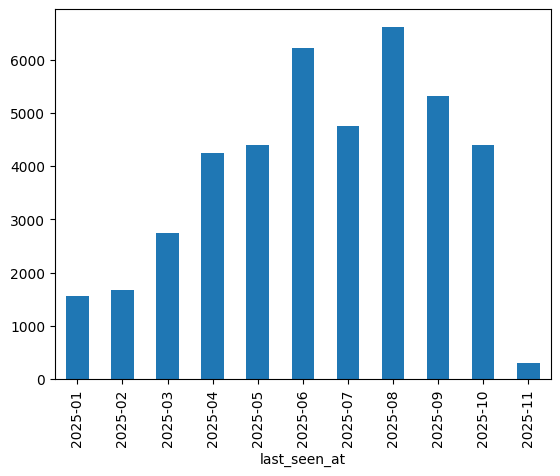

In [70]:
mapillary_mf_points_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


In [71]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this


zeitspanne = 9

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_mf_points_cw_temp = mapillary_mf_points_cw[
    mapillary_mf_points_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= zeitspanne, axis=1)
]
len(mapillary_mf_points_cw_temp)

13549

<Axes: xlabel='last_seen_at'>

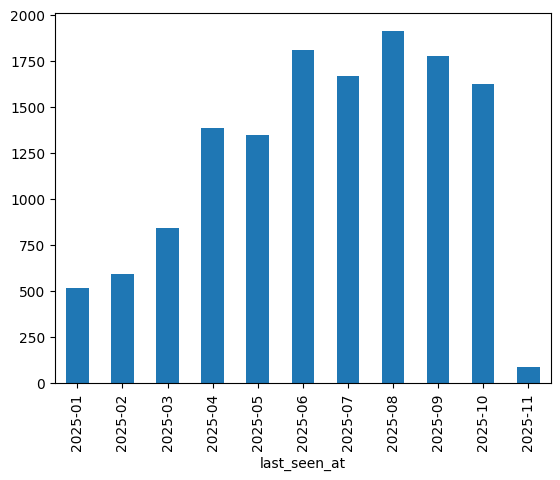

In [72]:
mapillary_mf_points_cw_temp.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")



<Axes: >

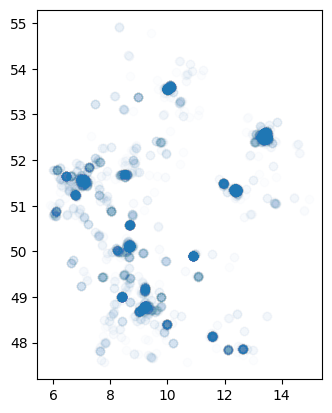

In [73]:
mapillary_mf_points_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [74]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_mf_points_cw_temp.to_crs(25833).copy()
df_buffered_25 = mapillary_mf_points_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_25["geometry"] = df_buffered_25.geometry.buffer(25)


df_buffered_30 = df_buffered_30.to_crs(mapillary_mf_points_cw_temp.crs)
df_buffered_25 = df_buffered_25.to_crs(mapillary_mf_points_cw_temp.crs)


In [75]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [76]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_25 = mark_intersections(df_buffered_25, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
#df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [77]:
df_buffered_30["buffer_size"] = 30
df_buffered_25["buffer_size"] = 25

In [78]:
#df_buffered.id.unique()

In [79]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     13138
False      411
Name: count, dtype: int64

In [80]:
df_buffered_25.has_cw_intersection.value_counts()

has_cw_intersection
True     13094
False      455
Name: count, dtype: int64

In [81]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
#df_buffered_30.has_mw_intersection.value_counts()

In [82]:
#df_buffered_30.has_mw_intersection

In [83]:
#df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False)].copy()

len(df_buffered_25_false)

455

In [84]:
#df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False)].copy()

len(df_buffered_30_false)

411

In [85]:
df_buffered_25_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
342670,"POLYGON ((13.30085 52.4396, 13.30085 52.43958,...",2023-08-05,1216404979032121,2025-05-24,marking--discrete--symbol--bicycle,8797,5379,False,25
465979,"POLYGON ((13.33246 52.42546, 13.33246 52.42544...",2022-04-13,355058936570928,2025-05-24,marking--discrete--symbol--bicycle,8798,5380,False,25
569306,"POLYGON ((13.35641 52.46103, 13.35641 52.46101...",2023-03-19,963354441713983,2025-04-18,marking--discrete--symbol--bicycle,8799,5377,False,25
631059,"POLYGON ((13.36618 52.57235, 13.36617 52.57233...",2016-02-03,935189327825599,2025-06-07,marking--discrete--symbol--bicycle,8800,5369,False,25
633960,"POLYGON ((13.37847 52.56459, 13.37847 52.56457...",2023-08-17,1044549630043178,2025-07-17,marking--discrete--symbol--bicycle,8800,5369,False,25
...,...,...,...,...,...,...,...,...,...
33465308,"POLYGON ((8.60142 51.67352, 8.60142 51.6735, 8...",2023-04-23,853628973167262,2025-05-15,marking--discrete--symbol--bicycle,8583,5435,False,25
33465762,"POLYGON ((8.60728 51.67431, 8.60729 51.67429, ...",2023-04-08,868968691380617,2025-05-15,marking--discrete--symbol--bicycle,8583,5435,False,25
33467964,"POLYGON ((8.601 51.67188, 8.601 51.67186, 8.60...",2023-04-23,376425918126227,2025-04-22,marking--discrete--symbol--bicycle,8583,5436,False,25
33709352,"POLYGON ((8.78768 51.99027, 8.78768 51.99025, ...",2022-06-25,1188642705262623,2025-06-23,marking--discrete--symbol--bicycle,8591,5412,False,25


In [86]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_25_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
30    411
25     44
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [87]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({25: 1, 30: 0}).astype("Int64")

In [88]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio
1701832,"POLYGON ((13.41025 52.51077, 13.41025 52.51075...",2021-07-13,539724197058850,2025-07-08,marking--discrete--symbol--bicycle,8802,5373,False,25,1
1732086,"POLYGON ((13.41018 52.51077, 13.41018 52.51075...",2016-01-30,1590765654768807,2025-08-15,marking--discrete--symbol--bicycle,8802,5373,False,25,1
1517072,"POLYGON ((13.42431 52.50149, 13.42431 52.50147...",2020-11-10,481221696450020,2025-07-01,marking--discrete--symbol--bicycle,8802,5374,False,25,1
1521273,"POLYGON ((13.41679 52.5018, 13.41679 52.50178,...",2023-05-11,157574170603413,2025-06-26,marking--discrete--symbol--bicycle,8802,5374,False,25,1
1548668,"POLYGON ((13.42426 52.5015, 13.42426 52.50148,...",2021-12-26,443587687238826,2025-09-22,marking--discrete--symbol--bicycle,8802,5374,False,25,1
...,...,...,...,...,...,...,...,...,...,...
4624539,"POLYGON ((8.92734 48.47285, 8.92734 48.47282, ...",2024-04-27,1532114970687715,2025-04-30,marking--discrete--symbol--bicycle,8598,5663,False,30,0
4777748,"POLYGON ((9.01065 48.79301, 9.01065 48.79298, ...",2018-04-08,200845148552127,2025-10-10,marking--discrete--symbol--bicycle,8602,5640,False,30,0
4782790,"POLYGON ((9.01116 48.79094, 9.01116 48.79091, ...",2018-04-08,200836605219648,2025-10-10,marking--discrete--symbol--bicycle,8602,5641,False,30,0
3657981,"POLYGON ((8.46525 49.48761, 8.46526 49.48759, ...",2024-08-23,3915587938764551,2025-08-30,marking--discrete--symbol--bicycle,8577,5592,False,30,0


In [89]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

In [90]:
import json
import requests

#### clean up from existing maproulette challenge

In [93]:
### import the the flagged (not created, fixed) tasks from the challenge. 

# challenge_gdf = gpd.read_file("challenge_53882_data_f_mr.geojson")
#challenge_gdf.head()

with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)
API_KEY = config["API_KEY_MAPROULETTE"]

CHALLENGE_ID = 53882
BASE_URL = "https://maproulette.org/api/v2"

headers = {"apiKey": API_KEY}

# Single request to get all tasks as GeoJSON
r = requests.get(
    f"{BASE_URL}/challenge/view/{CHALLENGE_ID}",
    headers=headers
)
r.raise_for_status()
geojson_data = r.json()

# Convert directly to GeoDataFrame
challenge_gdf = gpd.GeoDataFrame.from_features(geojson_data, crs='EPSG:4326')

challenge_gdf=challenge_gdf[~challenge_gdf.mr_taskStatus.isin(["Fixed", "Created", "Skipped"])]

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


452

### retrieve the image ID for the map features

In [94]:
df_process_img= df_buffered_both_false.copy()
#df_process_img= df_buffered_both_false_no_challenge.copy()

In [95]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 455/455 [00:51<00:00,  8.78it/s]


In [96]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio,image_id
1701832,"POLYGON ((13.41025 52.51077, 13.41025 52.51075...",2021-07-13,539724197058850,2025-07-08,marking--discrete--symbol--bicycle,8802,5373,False,25,1,299207701954090
1732086,"POLYGON ((13.41018 52.51077, 13.41018 52.51075...",2016-01-30,1590765654768807,2025-08-15,marking--discrete--symbol--bicycle,8802,5373,False,25,1,739879234260492
1517072,"POLYGON ((13.42431 52.50149, 13.42431 52.50147...",2020-11-10,481221696450020,2025-07-01,marking--discrete--symbol--bicycle,8802,5374,False,25,1,803434010547977
1521273,"POLYGON ((13.41679 52.5018, 13.41679 52.50178,...",2023-05-11,157574170603413,2025-06-26,marking--discrete--symbol--bicycle,8802,5374,False,25,1,1276267269910643
1548668,"POLYGON ((13.42426 52.5015, 13.42426 52.50148,...",2021-12-26,443587687238826,2025-09-22,marking--discrete--symbol--bicycle,8802,5374,False,25,1,645234573582969


In [97]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio,image_id
13050089,POINT (8.6921 50.14658),2019-01-03,515433849821306,2025-01-04,marking--discrete--symbol--bicycle,8587,5546,False,30,0,131079308958449
1313428,POINT (13.40338 52.60274),2022-12-30,566851194886207,2025-01-12,marking--discrete--symbol--bicycle,8802,5367,False,30,0,212899211137255
1313499,POINT (13.40373 52.60267),2022-12-30,566851184886208,2025-01-12,marking--discrete--symbol--bicycle,8802,5367,False,30,0,855517302220319
1466530,POINT (13.40492 52.53374),2019-05-12,287311776456271,2025-01-13,marking--discrete--symbol--bicycle,8802,5372,False,30,0,4192504937466739
13063392,POINT (8.70073 50.12269),2022-12-05,818781309232348,2025-01-18,marking--discrete--symbol--bicycle,8587,5547,False,30,0,6088716801161690
...,...,...,...,...,...,...,...,...,...,...,...
30529289,POINT (7.03079 51.43711),2024-07-24,1443153643044283,2025-10-20,marking--discrete--symbol--bicycle,8511,5453,False,30,0,801985218719130
12807596,POINT (8.67534 50.5812),2023-06-04,208988644877816,2025-10-31,marking--discrete--symbol--bicycle,8586,5515,False,30,0,985412812488409
12813958,POINT (8.67602 50.58092),2024-11-11,2061461584298175,2025-10-31,marking--discrete--symbol--bicycle,8586,5515,False,30,0,1640030796578424
24290812,POINT (12.65957 47.81912),2024-05-26,470016195525582,2025-11-02,marking--discrete--symbol--bicycle,8768,5707,False,30,0,1098276731277978


In [98]:
# Mapping dictionary
value_to_vz = {
    'marking--discrete--symbol--bicycle': 'Lane marking - symbol (bicycle)',
}


# Add new column based on mapping
centroids["MapFeaturePoint"] = centroids["value"].map(value_to_vz)

In [99]:
#centroids

In [100]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio,image_id,MapFeaturePoint
1701832,POINT (13.40988 52.51076),2021-07-13,539724197058850,2025-07-08,marking--discrete--symbol--bicycle,8802,5373,False,25,1,299207701954090,Lane marking - symbol (bicycle)
1732086,POINT (13.40982 52.51077),2016-01-30,1590765654768807,2025-08-15,marking--discrete--symbol--bicycle,8802,5373,False,25,1,739879234260492,Lane marking - symbol (bicycle)
1517072,POINT (13.42394 52.50149),2020-11-10,481221696450020,2025-07-01,marking--discrete--symbol--bicycle,8802,5374,False,25,1,803434010547977,Lane marking - symbol (bicycle)
1521273,POINT (13.41642 52.50179),2023-05-11,157574170603413,2025-06-26,marking--discrete--symbol--bicycle,8802,5374,False,25,1,1276267269910643,Lane marking - symbol (bicycle)
1548668,POINT (13.42389 52.5015),2021-12-26,443587687238826,2025-09-22,marking--discrete--symbol--bicycle,8802,5374,False,25,1,645234573582969,Lane marking - symbol (bicycle)
...,...,...,...,...,...,...,...,...,...,...,...,...
4624539,POINT (8.92693 48.47283),2024-04-27,1532114970687715,2025-04-30,marking--discrete--symbol--bicycle,8598,5663,False,30,0,7772699262776858,Lane marking - symbol (bicycle)
4777748,POINT (9.01024 48.79299),2018-04-08,200845148552127,2025-10-10,marking--discrete--symbol--bicycle,8602,5640,False,30,0,283078270178359,Lane marking - symbol (bicycle)
4782790,POINT (9.01075 48.79092),2018-04-08,200836605219648,2025-10-10,marking--discrete--symbol--bicycle,8602,5641,False,30,0,300141578306190,Lane marking - symbol (bicycle)
3657981,POINT (8.46484 49.48759),2024-08-23,3915587938764551,2025-08-30,marking--discrete--symbol--bicycle,8577,5592,False,30,0,524672806737908,Lane marking - symbol (bicycle)


In [101]:
centroids["prio_text"] = centroids["prio"].map({
    0: "🟩 Task mit hoher Wahrscheinlichkeit valide",
    1: "🟨 Task mit mittlerer Wahrscheinlichkeit valide",
    2: "🟥 Task mit eher geringer Wahrscheinlichkeit valide"
})

centroids[["prio", "prio_text"]].head()

,prio,prio_text
1701832,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
1732086,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
1517072,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
1521273,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
1548668,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide


In [102]:
#centroids.plot()

In [103]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&mapFeature[]=marking--discrete--symbol--bicycle"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Erkanntes Fahrrad-Symbol überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Map Feature an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst. Die nächste OSM-Radinfra ist mind. **{row["buffer_size"]} Meter** entfernt.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Die neueste Aufnahme hier ist von **{row["last_seen_at"]})**, die älteste ist von **{row["first_seen_at"]}**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            #"Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"],
            "name": row["prio_text"]
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [104]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_markings.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radinfrastuktur anhand von Mapillary-Map feature ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Fahrrad-Symbolen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Fahrrad-Symbol wurde **in Mapillary erkannt**.
- Das Fahrrad-Symbol wurde **mindestens 9 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''